# Supplementary Materials Figures

## "A multilevel trait-integration framework identifies key predictors of tomato salt tolerance"

*Cialli S, Carmassi G, Scatena G, Maggini R, Incrocci L, Mensuali A, Trivellini A*

Journal of Experimental Botany (JXB)

---

This notebook generates all supplementary figures and tables from the manuscript:

| Item | Description | Content |
|------|-------------|---------|  
| **Fig. S1** | Osmotic Regulation/Ionic Balance | Pathway activity heatmap |
| **Fig. S2** | Primary/Secondary Metabolism | Pathway activity heatmap |
| **Fig. S3** | Hormonal System | Pathway activity heatmap |
| **Fig. S4** | Morphology and Growth | Pathway activity heatmap |
| **Tab. S2** | Parameter Scores for CV and WR10 | Salt-tolerance ranking metrics |

All figures show pathway activity levels (Fold Change vs Control) under Severe Salinity Stress (S2).

### Methodological Note
All calculations use **all biological replicates** (not aggregated by DAT), because most parameters are from **destructive measurements** where each observation comes from a different plant. This approach maximizes statistical power while maintaining independence assumptions.

## Setup

## Cleanup Previous Output Files

Run this cell to remove any previously generated figures before re-running the notebook.

In [1]:
# Cleanup: Remove previously generated figures
import os
from pathlib import Path

# Set working directory to repository root
notebook_dir = Path.cwd()
if notebook_dir.name == 'notebooks':
    os.chdir(notebook_dir.parent)

output_dir = Path('scripts/supplementary_figures')

# Remove existing figure files
if output_dir.exists():
    removed = []
    for pattern in ['figure_S*.png', 'figure_S*.pdf']:
        for f in output_dir.glob(pattern):
            f.unlink()
            removed.append(f.name)
    
    if removed:
        print(f"Cleaned up {len(removed)} files:")
        for name in sorted(removed):
            print(f"  - {name}")
    else:
        print("No previous output files to clean up.")
else:
    print("Output directory does not exist yet.")

Cleaned up 8 files:
  - figure_S1_osmotic_regulation.pdf
  - figure_S1_osmotic_regulation.png
  - figure_S2_metabolism.pdf
  - figure_S2_metabolism.png
  - figure_S3_hormonal.pdf
  - figure_S3_hormonal.png
  - figure_S4_morphology.pdf
  - figure_S4_morphology.png


In [2]:
import os
import sys
from pathlib import Path

# Set working directory to repository root
notebook_dir = Path.cwd()
if notebook_dir.name == 'notebooks':
    os.chdir(notebook_dir.parent)
    
# Add scripts directory to path
sys.path.insert(0, str(Path.cwd() / 'scripts' / 'supplementary_figures'))

print(f"Working directory: {Path.cwd()}")
print(f"Data file exists: {(Path.cwd() / 'data' / 'master_dataset.csv').exists()}")

Working directory: /home/scatena/SRC/Tomato-Salt-Tolerance-Analysis
Data file exists: True


In [3]:
# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib for inline display
%matplotlib inline
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'Arial'

print("Packages loaded successfully!")

Packages loaded successfully!


## Load Data

In [4]:
# Load master dataset
data_path = Path('data/master_dataset.csv')
df = pd.read_csv(data_path)

print(f"Dataset loaded: {len(df)} rows, {len(df.columns)} columns")
print(f"\nVarieties: {df['Variety'].unique()}")
print(f"Treatments: {df['Treatment'].unique()}")

# Note: Using all replicates (not aggregated by DAT) because most parameters
# in SM figures are DESTRUCTIVE measurements (different plants at each DAT),
# making them independent replicates. This is the statistically correct approach.

Dataset loaded: 1173 rows, 69 columns

Varieties: ['CV' 'WR10' 'WR11' 'WR14' 'WR2' 'WR9']
Treatments: ['C' 'S1' 'S2']


## Common Functions

Functions used by all supplementary figures to calculate activity scores and statistical significance.

In [5]:
VARIETIES = ['CV', 'WR2', 'WR9', 'WR10', 'WR11', 'WR14']

def calculate_activity_score(df, param, variety):
    """
    Calculate Activity Score (Fold Change vs Control)
    Activity Score = (mean_S2 - mean_C) / mean_C
    
    Uses all replicates - appropriate for destructive measurements
    where each observation is from a different plant.
    """
    control_data = df[(df['Treatment'] == 'C') & (df['Variety'] == variety)][param].dropna()
    stress_data = df[(df['Treatment'] == 'S2') & (df['Variety'] == variety)][param].dropna()
    
    if len(control_data) == 0 or len(stress_data) == 0:
        return np.nan
    
    control_mean = control_data.mean()
    stress_mean = stress_data.mean()
    
    if control_mean == 0:
        return np.nan
    
    return (stress_mean - control_mean) / control_mean


def calculate_significance(df, param, variety):
    """
    Calculate statistical significance using Welch's t-test
    Returns: p-value and significance symbol
    
    Uses all replicates for robust statistical inference.
    """
    control_data = df[(df['Treatment'] == 'C') & (df['Variety'] == variety)][param].dropna()
    stress_data = df[(df['Treatment'] == 'S2') & (df['Variety'] == variety)][param].dropna()
    
    if len(control_data) < 2 or len(stress_data) < 2:
        return np.nan, ''
    
    try:
        t_stat, p_value = stats.ttest_ind(control_data, stress_data, equal_var=False)
        
        if p_value < 0.001:
            sig = '***'
        elif p_value < 0.01:
            sig = '**'
        elif p_value < 0.05:
            sig = '*'
        else:
            sig = ''
        
        return p_value, sig
    except:
        return np.nan, ''


def create_heatmap_data(df, params):
    """
    Create matrix for heatmap: parameters (rows) x varieties (columns)
    """
    data_matrix = []
    sig_matrix = []
    
    for param in params:
        row_data = []
        row_sig = []
        
        for variety in VARIETIES:
            score = calculate_activity_score(df, param, variety)
            p_val, sig = calculate_significance(df, param, variety)
            
            row_data.append(score)
            row_sig.append(sig)
        
        data_matrix.append(row_data)
        sig_matrix.append(row_sig)
    
    return np.array(data_matrix), sig_matrix


def plot_sm_heatmap(data_matrix, sig_matrix, params, title, vmin=-3, vmax=3, text_threshold=1.5):
    """
    Plot heatmap with activity scores and significance asterisks
    """
    fig, ax = plt.subplots(figsize=(10, max(6, len(params) * 0.8)))
    
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    im = ax.imshow(data_matrix, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8, pad=0.02)
    cbar.set_label('Activity Score (Fold Change vs Control)', fontsize=11, fontweight='bold')
    
    # Tick labels
    ax.set_xticks(range(len(VARIETIES)))
    ax.set_xticklabels(VARIETIES, fontsize=12, fontweight='bold')
    ax.set_yticks(range(len(params)))
    ax.set_yticklabels(params, fontsize=11)
    
    # Add values and asterisks
    for i in range(len(params)):
        for j in range(len(VARIETIES)):
            value = data_matrix[i, j]
            sig = sig_matrix[i][j]
            
            if np.isnan(value):
                text = 'N/A'
            else:
                text = f'{value:.2f}'
                if sig:
                    text = f'{value:.2f}\n{sig}'
            
            text_color = 'white' if abs(value) > text_threshold else 'black'
            ax.text(j, i, text, ha='center', va='center',
                   fontsize=10, fontweight='bold', color=text_color)
    
    # Grid lines
    for i in range(len(params) + 1):
        ax.axhline(i - 0.5, color='white', linewidth=0.5)
    for j in range(len(VARIETIES) + 1):
        ax.axvline(j - 0.5, color='white', linewidth=0.5)
    
    ax.tick_params(length=0)
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    
    plt.tight_layout()
    return fig

print("Functions defined successfully!")

Functions defined successfully!


---

## Figure S1: Osmotic Regulation/Ionic Balance

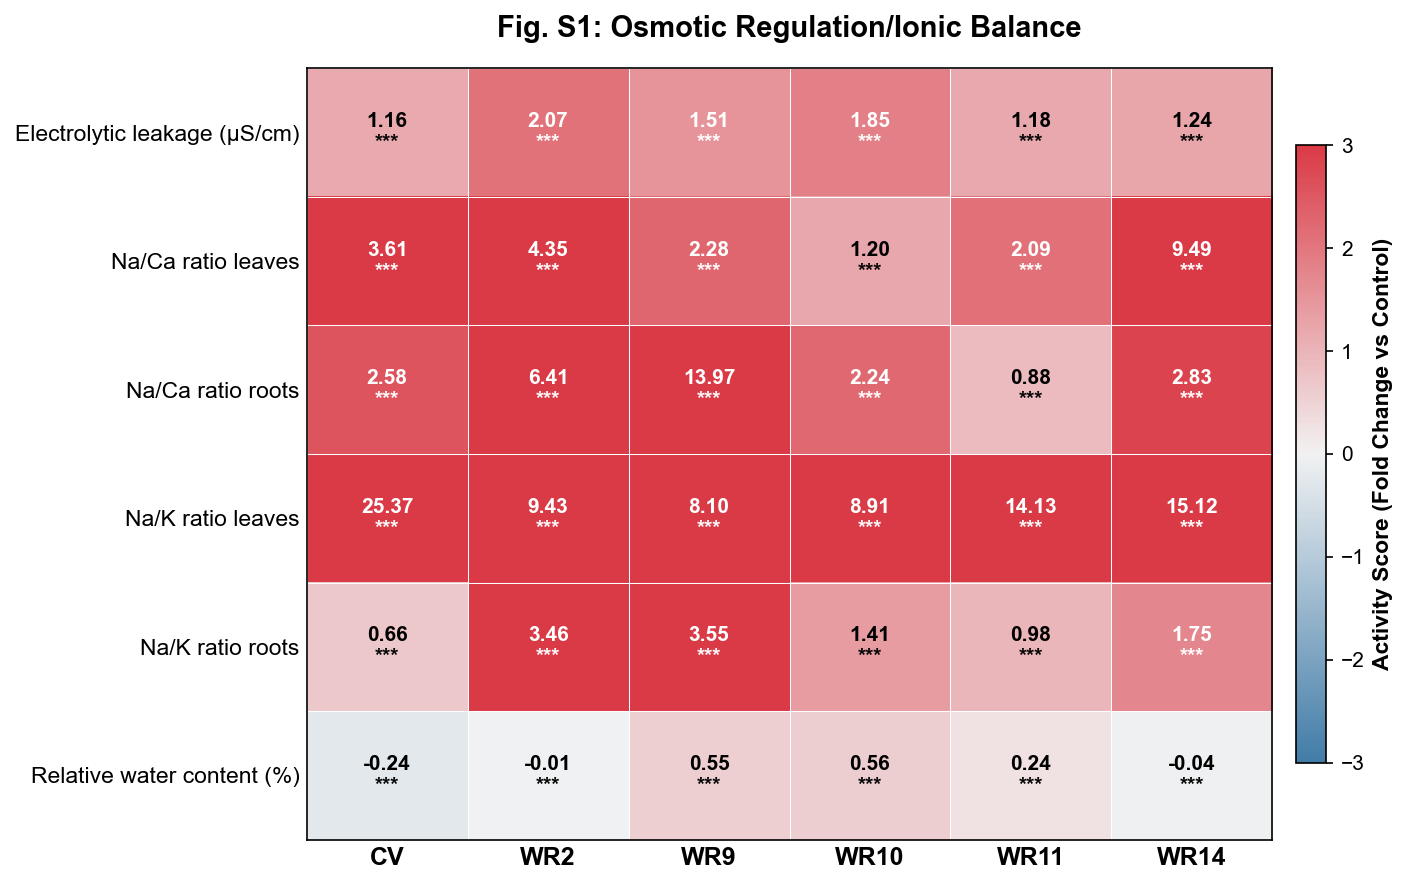

Figure S1 saved!


In [6]:
# Parameters for Figure S1
S1_PARAMS = [
    'Electrolytic leakage (μS/cm)',
    'Na/Ca ratio leaves',
    'Na/Ca ratio roots',
    'Na/K ratio leaves',
    'Na/K ratio roots',
    'Relative water content (%)'
]

# Create heatmap data
data_S1, sig_S1 = create_heatmap_data(df, S1_PARAMS)

# Plot
fig_S1 = plot_sm_heatmap(data_S1, sig_S1, S1_PARAMS, 
                         'Fig. S1: Osmotic Regulation/Ionic Balance',
                         vmin=-3, vmax=3, text_threshold=1.5)
plt.show()

# Save
fig_S1.savefig('scripts/supplementary_figures/figure_S1_osmotic_regulation.png', 
               dpi=300, bbox_inches='tight', facecolor='white')
print("Figure S1 saved!")

---

## Figure S2: Primary/Secondary Metabolism

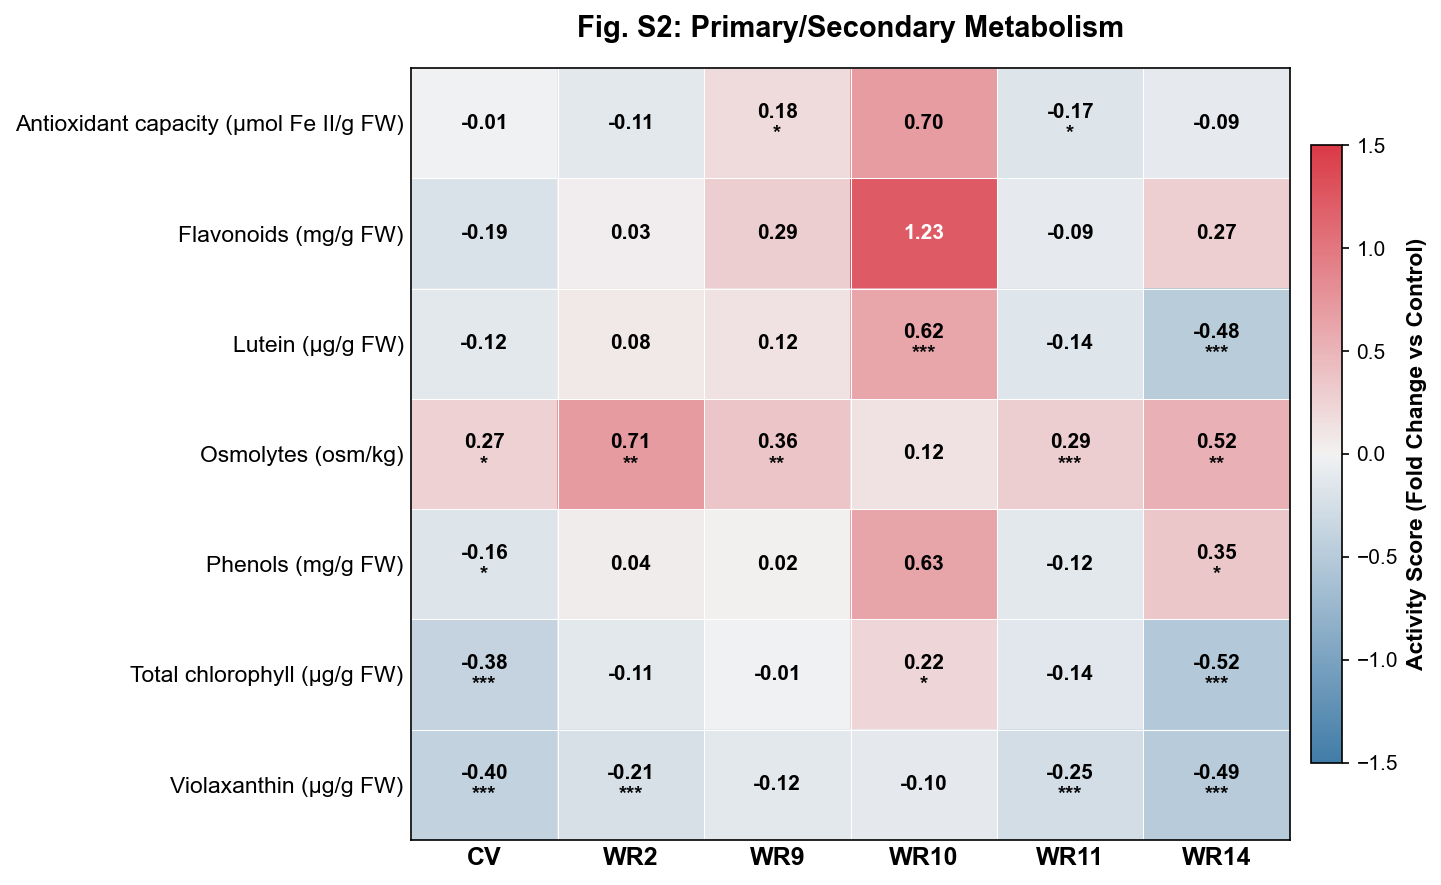

Figure S2 saved!


In [7]:
# Parameters for Figure S2
S2_PARAMS = [
    'Antioxidant capacity (μmol Fe II/g FW)',
    'Flavonoids (mg/g FW)',
    'Lutein (μg/g FW)',
    'Osmolytes (osm/kg)',
    'Phenols (mg/g FW)',
    'Total chlorophyll (μg/g FW)',
    'Violaxanthin (μg/g FW)'
]

# Create heatmap data
data_S2, sig_S2 = create_heatmap_data(df, S2_PARAMS)

# Plot
fig_S2 = plot_sm_heatmap(data_S2, sig_S2, S2_PARAMS, 
                         'Fig. S2: Primary/Secondary Metabolism',
                         vmin=-1.5, vmax=1.5, text_threshold=0.8)
plt.show()

# Save
fig_S2.savefig('scripts/supplementary_figures/figure_S2_metabolism.png', 
               dpi=300, bbox_inches='tight', facecolor='white')
print("Figure S2 saved!")

---

## Figure S3: Hormonal System

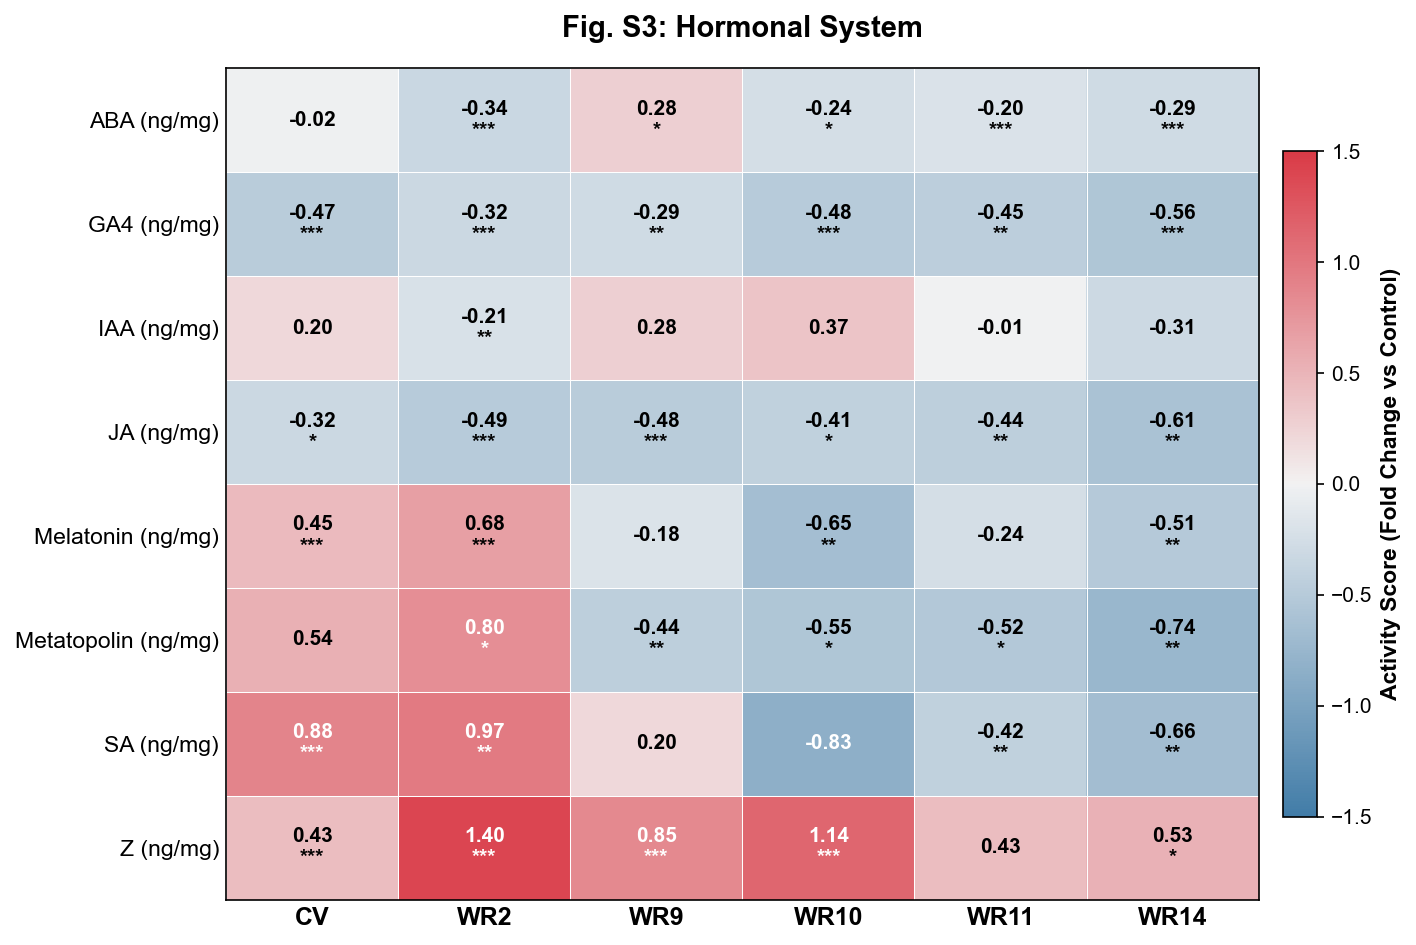

Figure S3 saved!


In [8]:
# Parameters for Figure S3
S3_PARAMS = [
    'ABA (ng/mg)',
    'GA4 (ng/mg)',
    'IAA (ng/mg)',
    'JA (ng/mg)',
    'Melatonin (ng/mg)',
    'Metatopolin (ng/mg)',
    'SA (ng/mg)',
    'Z (ng/mg)'
]

# Create heatmap data
data_S3, sig_S3 = create_heatmap_data(df, S3_PARAMS)

# Plot
fig_S3 = plot_sm_heatmap(data_S3, sig_S3, S3_PARAMS, 
                         'Fig. S3: Hormonal System',
                         vmin=-1.5, vmax=1.5, text_threshold=0.8)
plt.show()

# Save
fig_S3.savefig('scripts/supplementary_figures/figure_S3_hormonal.png', 
               dpi=300, bbox_inches='tight', facecolor='white')
print("Figure S3 saved!")

---

## Figure S4: Morphology and Growth

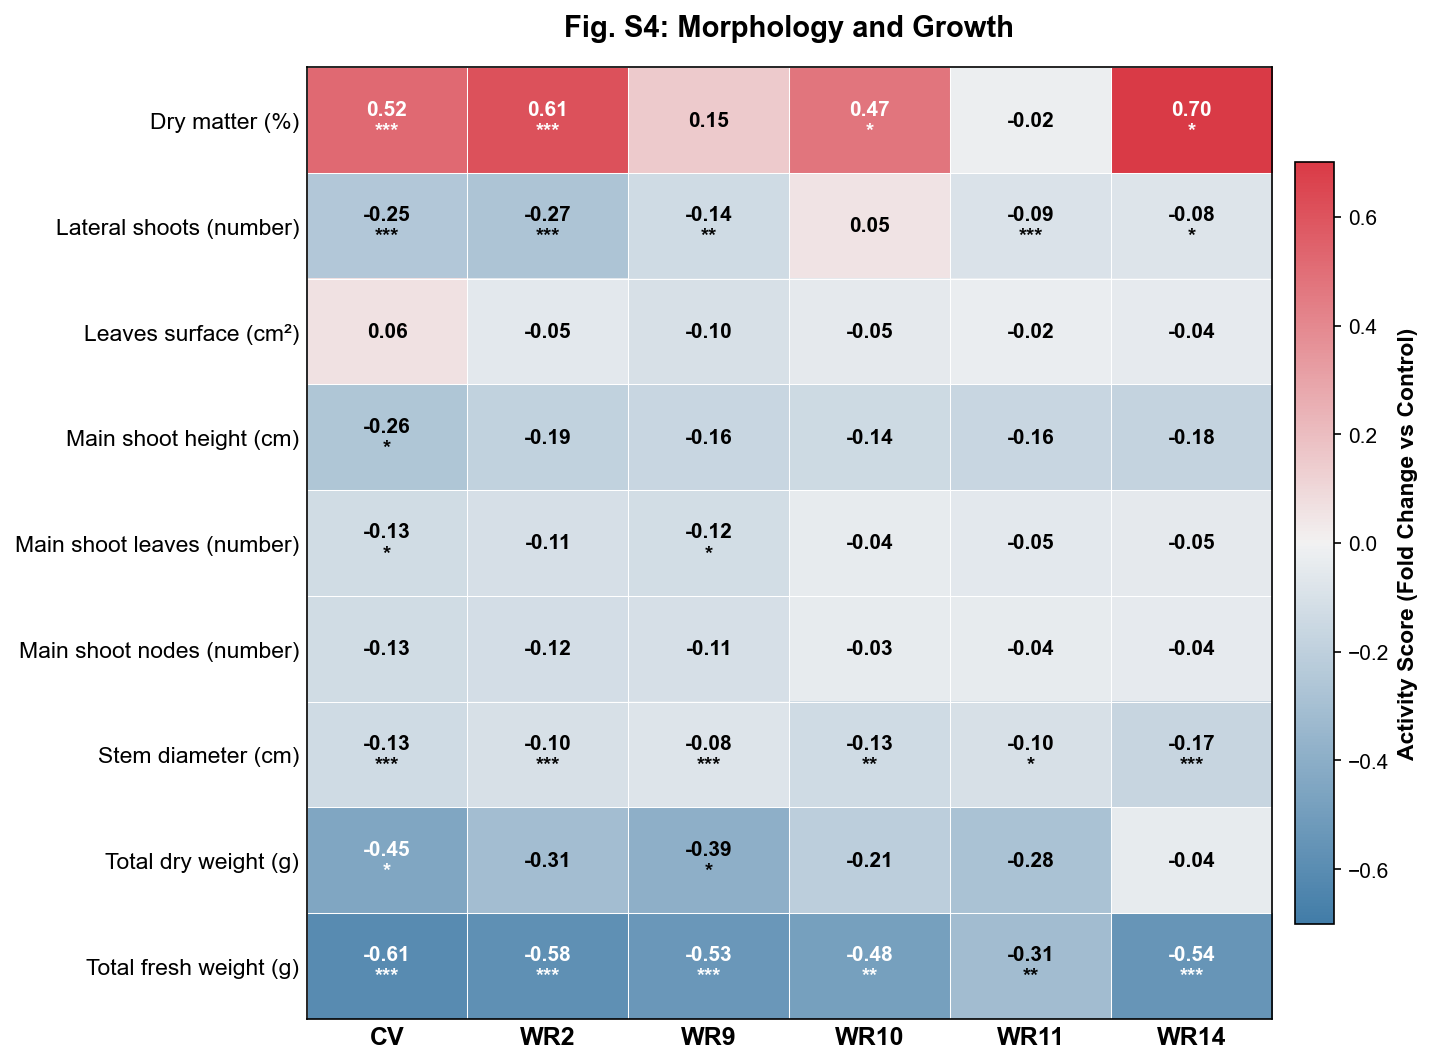

Figure S4 saved!


In [9]:
# Parameters for Figure S4
S4_PARAMS = [
    'Dry matter (%)',
    'Lateral shoots (number)',
    'Leaves surface (cm²)',
    'Main shoot height (cm)',
    'Main shoot leaves (number)',
    'Main shoot nodes (number)',
    'Stem diameter (cm)',
    'Total dry weight (g)',
    'Total fresh weight (g)'
]

# Create heatmap data
data_S4, sig_S4 = create_heatmap_data(df, S4_PARAMS)

# Plot
fig_S4 = plot_sm_heatmap(data_S4, sig_S4, S4_PARAMS, 
                         'Fig. S4: Morphology and Growth',
                         vmin=-0.7, vmax=0.7, text_threshold=0.4)
plt.show()

# Save
fig_S4.savefig('scripts/supplementary_figures/figure_S4_morphology.png', 
               dpi=300, bbox_inches='tight', facecolor='white')
print("Figure S4 saved!")

---

## Figures Summary

All 4 supplementary figures have been generated:

1. **Fig. S1**: Osmotic Regulation/Ionic Balance - Shows strong increases in ionic stress markers (Na/K, Na/Ca ratios, electrolytic leakage)
2. **Fig. S2**: Primary/Secondary Metabolism - Shows variable responses in metabolites across varieties
3. **Fig. S3**: Hormonal System - Shows complex hormonal responses, with GA4 and JA decreasing under stress
4. **Fig. S4**: Morphology and Growth - Shows general growth reduction under stress, with dry matter increasing

### Methodological Note
All calculations use **all biological replicates** (not aggregated by DAT), because most parameters are from **destructive measurements** where each observation comes from a different plant. This is the statistically correct approach that maximizes statistical power.

In [10]:
# List generated files
import os
output_dir = Path('scripts/supplementary_figures')
files = sorted(output_dir.glob('figure_S*.*'))
print("Generated files:")
for f in files:
    size_kb = f.stat().st_size / 1024
    print(f"  {f.name}: {size_kb:.1f} KB")

Generated files:
  figure_S1_osmotic_regulation.png: 263.5 KB
  figure_S2_metabolism.png: 292.9 KB
  figure_S3_hormonal.png: 304.3 KB
  figure_S4_morphology.png: 332.0 KB


---

## Table S2: Parameter Scores for CV and WR10

**Tab. S2** shows parameter scores for CV and WR10 across the three biological categories used in the salt-tolerance ranking:

1. **Performance Maintenance** - Growth and yield-related parameters
2. **Physiological Stability** - Photosynthesis and water status parameters
3. **Stress Marker Response** - Stress indicator parameters

Each parameter score is calculated from:
- **F-statistic** (40%): One-way ANOVA treatment effect strength
- **η² (eta-squared)** (40%): Effect size of treatment
- **% Change** (20%): Fold change from Control to S2

In [11]:
# Define the three biological categories for salt-tolerance ranking
CATEGORIES = {
    'Performance Maintenance': [
        'Main shoot height (cm)',
        'Main shoot leaves (number)', 
        'Total dry weight (g)',
        'Total fresh weight (g)',
        'Fruit set (trusses number)',
        'Flowering (trusses number)'
    ],
    'Physiological Stability': [
        'Stomatal conductance (μmol/sec)',
        'Relative water content (%)',
        'Total chlorophyll (μg/g FW)',
        'Fv/Fm'
    ],
    'Stress Marker Response': [
        'Electrolytic leakage (μS/cm)',
        'Na/K ratio leaves',
        'ABA (ng/mg)',
        'Osmolytes (osm/kg)'
    ]
}

def calculate_parameter_score(df, param, variety):
    """
    Calculate parameter score for salt-tolerance ranking.
    
    Score = 0.4 * F_normalized + 0.4 * eta_squared_normalized + 0.2 * pct_change_normalized
    
    Returns: dict with F, eta_squared, pct_change, and final score
    """
    # Get Control and S2 data for this variety
    control = df[(df['Treatment'] == 'C') & (df['Variety'] == variety)][param].dropna()
    stress = df[(df['Treatment'] == 'S2') & (df['Variety'] == variety)][param].dropna()
    
    if len(control) < 2 or len(stress) < 2:
        return {'F': np.nan, 'eta_sq': np.nan, 'pct_change': np.nan, 'score': np.nan}
    
    # 1. One-way ANOVA F-statistic
    try:
        f_stat, p_val = stats.f_oneway(control, stress)
    except:
        f_stat = np.nan
    
    # 2. Eta-squared (effect size)
    # η² = SS_between / SS_total
    all_data = np.concatenate([control, stress])
    grand_mean = all_data.mean()
    
    ss_between = len(control) * (control.mean() - grand_mean)**2 + \
                 len(stress) * (stress.mean() - grand_mean)**2
    ss_total = np.sum((all_data - grand_mean)**2)
    
    eta_sq = ss_between / ss_total if ss_total > 0 else np.nan
    
    # 3. Percent change (fold change * 100)
    if control.mean() != 0:
        pct_change = abs((stress.mean() - control.mean()) / control.mean() * 100)
    else:
        pct_change = np.nan
    
    return {
        'F': f_stat,
        'eta_sq': eta_sq * 100,  # Convert to percentage
        'pct_change': pct_change
    }


def generate_table_s2(df):
    """Generate Table S2 data for CV and WR10"""
    
    results = []
    
    for category, params in CATEGORIES.items():
        for param in params:
            if param not in df.columns:
                continue
                
            for variety in ['CV', 'WR10']:
                scores = calculate_parameter_score(df, param, variety)
                
                results.append({
                    'Category': category,
                    'Parameter': param,
                    'Variety': variety,
                    'F-statistic': scores['F'],
                    'η² (%)': scores['eta_sq'],
                    '% Change': scores['pct_change']
                })
    
    return pd.DataFrame(results)

# Generate Table S2
table_s2 = generate_table_s2(df)

print("Table S2: Parameter Scores for CV and WR10")
print("=" * 80)

Table S2: Parameter Scores for CV and WR10


In [12]:
# Display Table S2 as formatted DataFrames
from IPython.display import display, HTML

print("=" * 80)
print("TABLE S2: Parameter Scores for CV and WR10")
print("=" * 80)

# Create a nicely formatted table for CV
print("\n### CV (Domesticated Cultivar)")
cv_table = table_s2[table_s2['Variety'] == 'CV'].copy()
cv_table = cv_table.drop('Variety', axis=1)
cv_table = cv_table.round(2)
display(cv_table.style.format({
    'F-statistic': '{:.2f}',
    'η² (%)': '{:.2f}',
    '% Change': '{:.2f}'
}).set_properties(**{'text-align': 'center'}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]}
]))

TABLE S2: Parameter Scores for CV and WR10

### CV (Domesticated Cultivar)


,Category,Parameter,F-statistic,η² (%),% Change
0,Performance Maintenance,Main shoot height (cm),5.50,4.72,26.22
2,Performance Maintenance,Main shoot leaves (number),4.84,3.59,12.59
4,Performance Maintenance,Total dry weight (g),7.08,17.23,44.84
6,Performance Maintenance,Total fresh weight (g),32.87,49.15,60.67
8,Performance Maintenance,Fruit set (trusses number),0.18,0.14,7.87
10,Performance Maintenance,Flowering (trusses number),1.25,0.96,15.47
12,Physiological Stability,Stomatal conductance (μmol/sec),inf,100.00,75.78
14,Physiological Stability,Relative water content (%),inf,100.00,23.67
16,Physiological Stability,Total chlorophyll (μg/g FW),22.63,39.96,37.60
18,Physiological Stability,Fv/Fm,2.27,6.27,2.30


In [13]:
# Display Table S2 for WR10
print("\n### WR10 (Wild Relative - Most Tolerant)")
wr10_table = table_s2[table_s2['Variety'] == 'WR10'].copy()
wr10_table = wr10_table.drop('Variety', axis=1)
wr10_table = wr10_table.round(2)
display(wr10_table.style.format({
    'F-statistic': '{:.2f}',
    'η² (%)': '{:.2f}',
    '% Change': '{:.2f}'
}).set_properties(**{'text-align': 'center'}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]}
]))


### WR10 (Wild Relative - Most Tolerant)


,Category,Parameter,F-statistic,η² (%),% Change
1,Performance Maintenance,Main shoot height (cm),1.44,1.33,13.97
3,Performance Maintenance,Main shoot leaves (number),0.30,0.25,3.73
5,Performance Maintenance,Total dry weight (g),0.69,2.25,21.30
7,Performance Maintenance,Total fresh weight (g),18.25,37.83,48.33
9,Performance Maintenance,Fruit set (trusses number),0.47,0.38,14.08
11,Performance Maintenance,Flowering (trusses number),0.47,0.38,10.02
13,Physiological Stability,Stomatal conductance (μmol/sec),inf,100.00,70.39
15,Physiological Stability,Relative water content (%),inf,100.00,56.34
17,Physiological Stability,Total chlorophyll (μg/g FW),7.26,19.47,22.50
19,Physiological Stability,Fv/Fm,0.96,3.10,1.96


In [14]:
# Create side-by-side comparison table (CV vs WR10)
print("\n" + "=" * 80)
print("COMPARISON: CV vs WR10 (% Change from Control)")
print("=" * 80)

# Pivot table for comparison
comparison = table_s2.pivot_table(
    index=['Category', 'Parameter'], 
    columns='Variety', 
    values='% Change'
).round(2)

# Reorder categories
cat_order = ['Performance Maintenance', 'Physiological Stability', 'Stress Marker Response']
comparison = comparison.reindex(cat_order, level=0)

display(comparison.style.format('{:.2f}').background_gradient(cmap='YlOrRd', axis=None))


COMPARISON: CV vs WR10 (% Change from Control)


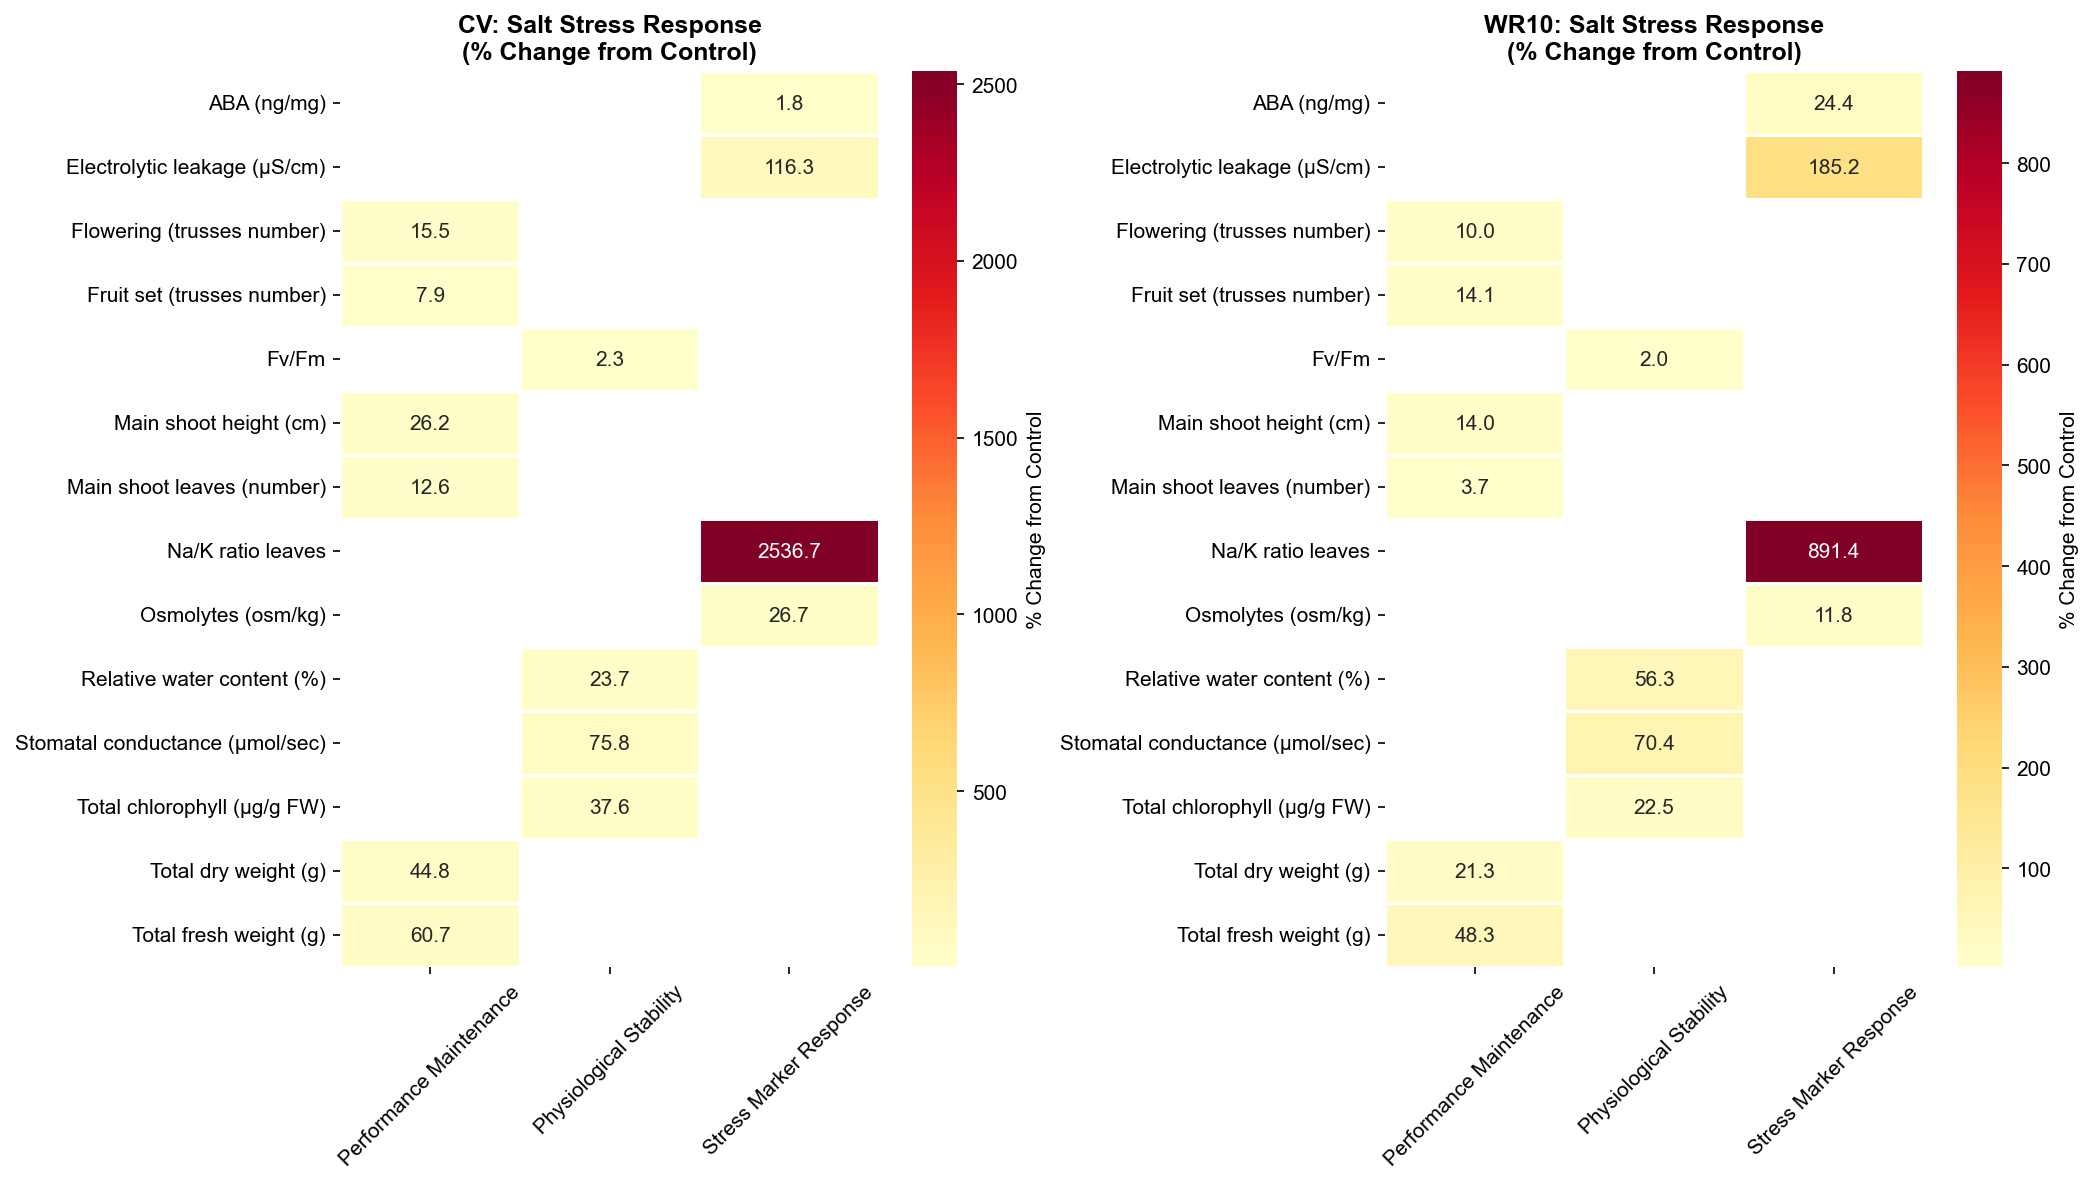


Table S2 heatmap saved to: scripts/supplementary_figures/table_S2_heatmap.png


In [15]:
# Visual heatmap comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

for idx, variety in enumerate(['CV', 'WR10']):
    ax = axes[idx]
    var_data = table_s2[table_s2['Variety'] == variety].copy()
    
    # Pivot for heatmap - Parameter x Category with % Change values
    pivot_data = var_data.pivot(index='Parameter', columns='Category', values='% Change')
    
    # Reorder columns by category
    category_order = ['Performance Maintenance', 'Physiological Stability', 'Stress Marker Response']
    pivot_data = pivot_data.reindex(columns=category_order)
    
    # Create heatmap
    sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax,
                cbar_kws={'label': '% Change from Control'},
                linewidths=0.5, linecolor='white')
    ax.set_title(f'{variety}: Salt Stress Response\n(% Change from Control)', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('scripts/supplementary_figures/table_S2_heatmap.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("\nTable S2 heatmap saved to: scripts/supplementary_figures/table_S2_heatmap.png")

In [16]:
# Summary statistics and save to CSV
print("=" * 80)
print("SUMMARY: Average Scores by Category")
print("=" * 80)

summary = table_s2.groupby(['Variety', 'Category']).agg({
    'F-statistic': 'mean',
    'η² (%)': 'mean', 
    '% Change': 'mean'
}).round(2)

display(summary.style.format('{:.2f}').background_gradient(cmap='Blues', axis=None))

# Save to CSV
table_s2.to_csv('scripts/supplementary_figures/table_S2_parameter_scores.csv', index=False)
print("\n✅ Table S2 saved to: scripts/supplementary_figures/table_S2_parameter_scores.csv")

SUMMARY: Average Scores by Category



✅ Table S2 saved to: scripts/supplementary_figures/table_S2_parameter_scores.csv
